Project to detect condition of throat (norm or red) by Alex Bocharov(skype bam271074)


In [0]:
# load libs and state random state

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
#random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [0]:
# connect to google drive where dataset

from google.colab import drive
drive.mount ('/content/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls

gdrive	sample_data


In [0]:
!cp /content/gdrive/'My Drive'/dataset_gorlo/dataset_gorlo.zip .

In [0]:
!ls

dataset_gorlo.zip  gdrive  sample_data


In [0]:
!ls /content/gdrive/'My Drive'/dataset_gorlo/

dataset_gorlo.zip  test  train


In [0]:
print(os.listdir("../content/gdrive"))

data_root = '../content/gdrive/My Drive/dataset_gorlo'
print(os.listdir(data_root))

['.shortcut-targets-by-id', 'My Drive', '.Trash']
['test', 'train', 'dataset_gorlo.zip']


Let s make validatioin files

In [0]:
import shutil 
from tqdm import tqdm


train_dir = 'train'
val_dir = 'val'
#print (os.listdir (train_dir))
#print (os.listdir (val_dir))

class_names = ['0_norm', '1_red']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 5 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 25/25 [00:06<00:00,  4.12it/s]


Let s make dataloaders. We clip files for better recognition

In [0]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 5
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [0]:
len(train_dataloader), len(train_dataset)

(9, 44)

Check file

make func for viewing

In [0]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

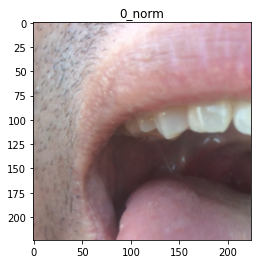

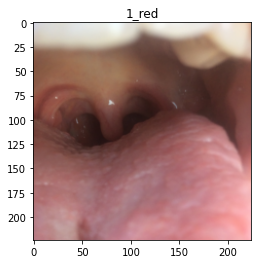

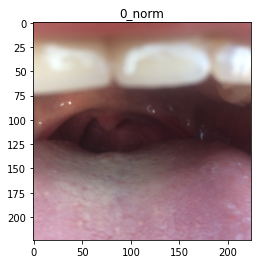

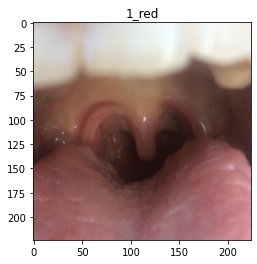

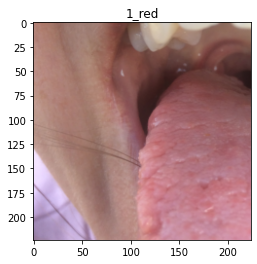

In [0]:
X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [0]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                #forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

model resnet18-pretrained=True

In [0]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam (model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
train_model(model, loss, optimizer, scheduler, num_epochs=10);

Epoch 0/9:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 9/9 [00:08<00:00,  1.12it/s]

train Loss: 0.6996 Acc: 0.5944



100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

val Loss: 1.0003 Acc: 0.4000
Epoch 1/9:



100%|██████████| 9/9 [00:07<00:00,  1.16it/s]

train Loss: 0.6111 Acc: 0.6833



100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

val Loss: 0.5934 Acc: 0.4667
Epoch 2/9:



100%|██████████| 9/9 [00:07<00:00,  1.17it/s]

train Loss: 0.5290 Acc: 0.8222



100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

val Loss: 0.7051 Acc: 0.4667
Epoch 3/9:



100%|██████████| 9/9 [00:07<00:00,  1.17it/s]

train Loss: 0.3956 Acc: 0.9056



100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

val Loss: 0.6622 Acc: 0.4667
Epoch 4/9:



100%|██████████| 9/9 [00:07<00:00,  1.16it/s]

train Loss: 0.5262 Acc: 0.7333



100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

val Loss: 0.9145 Acc: 0.4667
Epoch 5/9:



100%|██████████| 9/9 [00:07<00:00,  1.16it/s]

train Loss: 0.5590 Acc: 0.6722



100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

val Loss: 0.5209 Acc: 0.4667
Epoch 6/9:



100%|██████████| 9/9 [00:07<00:00,  1.17it/s]

train Loss: 0.4344 Acc: 0.8389



100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

val Loss: 0.5045 Acc: 0.4667
Epoch 7/9:



100%|██████████| 9/9 [00:07<00:00,  1.16it/s]

train Loss: 0.3893 Acc: 0.8389



100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

val Loss: 0.4809 Acc: 0.4667
Epoch 8/9:



100%|██████████| 9/9 [00:07<00:00,  1.16it/s]

train Loss: 0.2916 Acc: 0.9778



100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

val Loss: 0.6190 Acc: 0.4667
Epoch 9/9:



100%|██████████| 9/9 [00:07<00:00,  1.16it/s]

train Loss: 0.3133 Acc: 0.9500



100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

val Loss: 0.6145 Acc: 0.4667


In [0]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [0]:
!ls /content/gdrive/'My Drive'/dataset_gorlo/test

IMG_3967_norm.jpg  IMG_3970_norm.jpg  IMG_4557_red.jpg	IMG_4561_red.jpg
IMG_3968_norm.jpg  IMG_3974_norm.jpg  IMG_4558_red.jpg
IMG_3969_norm.jpg  IMG_4556_red.jpg   IMG_4559_red.jpg


In [0]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


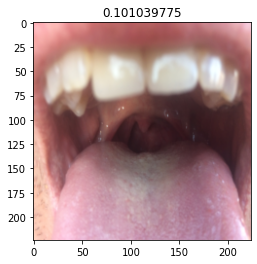

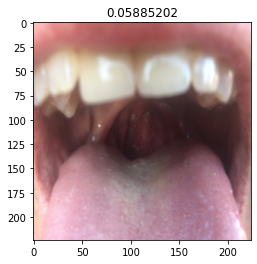

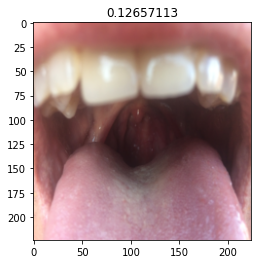

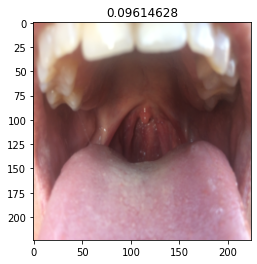

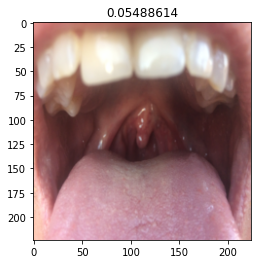

In [0]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [0]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [0]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'red' if pred > 0.5 else 'norm')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=10)

,label
id,
IMG_3967_norm,norm
IMG_3968_norm,norm
IMG_3969_norm,norm
IMG_3970_norm,norm
IMG_3974_norm,norm
IMG_4556_red,norm
IMG_4557_red,norm
IMG_4558_red,red
IMG_4559_red,red


In [0]:

torch.save (model, 'model_gorlo.h5')

In [0]:
from google.colab import files

files.download('model_gorlo.h5')